# CS 512 Computer Vision - Spring 2025
# Project title -- EfficientViT: Memory-Efficient Vision Transformer

## By Arpitha Ramakrishnaiah (A20523821) & Urjita Saxena (A20578349)

This notebook implements the EfficientViT architecture from the paper ["EfficientViT: Memory Efficient Vision Transformer with Cascaded Group Attention"](https://arxiv.org/abs/2306.05734).

##  Features:
- Custom implementation of **Cascaded Group Attention (CGA)**
- Vision Transformer with **sandwich layout**: FFN → CGA → FFN
- Trained on **CIFAR-100** with full performance evaluation
- Includes:
  - Accuracy, Precision, Recall, F1
  - AUC (macro and per-class)
  - Confusion Matrix
  - Attention Map Visualization
  - mIOU evaluation (optional for segmentation)
  - FPS / FLOPs / Parameters benchmarks

## How to Use:
1. Upload the `efficientvit_cifar100.pth` file
2. Run all cells sequentially or rerun only evaluation/visualization blocks after model load
3. Modify the number of transformer blocks or embed dim for scaling

## Dependencies:
- PyTorch
- torchvision
- scikit-learn
- matplotlib
- tqdm
- thop or ptflops (for FLOPs estimation)


In [ ]:
# Step 0: Install Required Libraries
!pip install torch torchvision matplotlib scikit-learn


###  Patch Embedding Layer
This block defines the `PatchEmbedding` module that converts input images into patch tokens using a Conv2D projection. It adds a `[CLS]` token and positional encodings for transformer input.


In [ ]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=192):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

    def forward(self, x):
        B = x.shape[0]
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        return x


In [ ]:
patch_embed = PatchEmbedding(img_size=224, patch_size=16, embed_dim=192)
sample = torch.randn(2, 3, 224, 224)
out = patch_embed(sample)
print("Output shape:", out.shape)


Output shape: torch.Size([2, 197, 192])


###  FeedForward Network
A two-layer feedforward network (MLP) with GELU activation and dropout. Used inside the EfficientViT block before and after the attention module.


In [ ]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0.1):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


In [ ]:
ffn = FeedForward(embed_dim=192, hidden_dim=768)
sample = torch.randn(2, 197, 192)
out = ffn(sample)
print("FeedForward Output Shape:", out.shape)


FeedForward Output Shape: torch.Size([2, 197, 192])


In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim=192, num_heads=3, dropout=0.1):
        super(MultiHeadSelfAttention, self).__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.out = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape

        qkv = self.qkv(x)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn_scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = torch.softmax(attn_scores, dim=-1)
        attn = self.dropout(attn)

        out = attn @ v
        out = out.transpose(1, 2).reshape(B, N, C)
        out = self.out(out)
        return out


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
mhsa = MultiHeadSelfAttention(embed_dim=192, num_heads=3).to(device)
sample_input = torch.randn(2, 197, 192).to(device)
mhsa_output = mhsa(sample_input)
print("MHSA Output Shape:", mhsa_output.shape)


MHSA Output Shape: torch.Size([2, 197, 192])


###  Cascaded Group Attention
Implements the core idea of EfficientViT: multiple per-head attention branches operating on channel groups. Outputs are concatenated and projected.


In [ ]:
class CascadedGroupAttention(nn.Module):
    def __init__(self, embed_dim=192, num_heads=3, dropout=0.1):
        super(CascadedGroupAttention, self).__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Separate q, k, v for each head input group
        self.qkv = nn.ModuleList([
            nn.Linear(self.head_dim, self.head_dim * 3) for _ in range(num_heads)
        ])
        self.out = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        chunks = torch.chunk(x, self.num_heads, dim=2)

        head_outputs = []
        for i in range(self.num_heads):
            x_i = chunks[i]
            qkv = self.qkv[i](x_i).reshape(B, N, 3, self.head_dim).permute(2, 0, 1, 3)
            q, k, v = qkv[0], qkv[1], qkv[2]

            attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
            attn = torch.softmax(attn_scores, dim=-1)
            attn = self.dropout(attn)

            out = torch.matmul(attn, v)
            head_outputs.append(out)

        out = torch.cat(head_outputs, dim=2)
        out = self.out(out)
        return out


In [ ]:
cga = CascadedGroupAttention(embed_dim=192, num_heads=3).to(device)
cga_out = cga(torch.randn(2, 197, 192).to(device))
print("CGA Output Shape:", cga_out.shape)


CGA Output Shape: torch.Size([2, 197, 192])


### EfficientViT Block
Defines a transformer block with the "sandwich layout" as per the paper: FFN → CGA → FFN. Includes LayerNorm and residual connections.


In [ ]:
class EfficientViTBlock(nn.Module):
    def __init__(self, embed_dim=192, ffn_dim=768, num_heads=3, dropout=0.1):
        super(EfficientViTBlock, self).__init__()

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)

        self.ffn1 = FeedForward(embed_dim, ffn_dim, dropout)
        # self.attn = CascadedGroupAttention(embed_dim, num_heads, dropout)

        self.attn = CascadedGroupAttention(embed_dim, num_heads, dropout)
        self.attn.return_attn = True

        self.ffn2 = FeedForward(embed_dim, ffn_dim, dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Sandwich Layout
        x = x + self.dropout(self.ffn1(self.norm1(x)))  # FFN 1
        x = x + self.dropout(self.attn(self.norm2(x)))  # CGA
        x = x + self.dropout(self.ffn2(self.norm3(x)))  # FFN 2
        return x


In [ ]:
block = EfficientViTBlock(embed_dim=192, ffn_dim=768, num_heads=3)
sample = torch.randn(2, 197, 192)
out = block(sample)
print("EfficientViT Block Output Shape:", out.shape)


EfficientViT Block Output Shape: torch.Size([2, 197, 192])


###  EfficientViT Model
Assembles the full Vision Transformer using patch embedding, multiple EfficientViT blocks, final normalization, and a classification head applied to the `[CLS]` token.


In [ ]:
class EfficientViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3,
                 embed_dim=192, ffn_dim=768, num_heads=3,
                 depth=4, num_classes=100, dropout=0.2):
        super(EfficientViT, self).__init__()

        self.patch_embed = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim
        )

        self.blocks = nn.ModuleList([
            EfficientViTBlock(embed_dim, ffn_dim, num_heads, dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        cls_token = x[:, 0]
        logits = self.head(cls_token)
        return logits


In [ ]:
model = EfficientViT()
dummy_input = torch.randn(2, 3, 224, 224)
output = model(dummy_input)
print("Final Output Shape:", output.shape)


Final Output Shape: torch.Size([2, 100])


Create EfficientVit Model Variants (M0–M5)

In [ ]:
# EfficientViT Variant Configurations
efficientvit_configs = {
    "M0": {"embed_dim": 128, "ffn_dim": 512, "num_heads": 2, "depth": 3},
    "M1": {"embed_dim": 160, "ffn_dim": 640, "num_heads": 2, "depth": 4},
    "M2": {"embed_dim": 192, "ffn_dim": 768, "num_heads": 3, "depth": 4},
    "M3": {"embed_dim": 224, "ffn_dim": 896, "num_heads": 4, "depth": 5},
    "M4": {"embed_dim": 256, "ffn_dim": 1024, "num_heads": 4, "depth": 6},
    "M5": {"embed_dim": 320, "ffn_dim": 1280, "num_heads": 5, "depth": 7},
}

def create_efficientvit(variant="M2", img_size=224, patch_size=16, in_channels=3, num_classes=100, dropout=0.1):
    cfg = efficientvit_configs[variant]
    return EfficientViT(
        img_size=img_size,
        patch_size=patch_size,
        in_channels=in_channels,
        embed_dim=cfg["embed_dim"],
        ffn_dim=cfg["ffn_dim"],
        num_heads=cfg["num_heads"],
        depth=cfg["depth"],
        num_classes=num_classes,
        dropout=dropout
    )


In [ ]:
model = create_efficientvit("M2").to(device)
print(model)


EfficientViT(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-3): 4 x EfficientViTBlock(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (norm3): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (ffn1): FeedForward(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attn): CascadedGroupAttention(
        (qkv): ModuleList(
          (0-2): 3 x Linear(in_features=64, out_features=192, bias=True)
        )
        (out): Linear(in_features=192, out_features=192, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn2): FeedForward(
        (fc1): Linear(in_features=192, out_features=768, b

## Save/Load Functions for weights

In [ ]:
#  Save model weights
def save_model(model, path="efficientvit_checkpoint.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

#  Load model weights
def load_model(model, path="efficientvit_checkpoint.pth", device='cpu'):
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    print(f"Model loaded from {path}")
    return model


###  Model Training Loop
Trains the EfficientViT model using CrossEntropyLoss and the AdamW optimizer. Loss is tracked across epochs for performance evaluation.


In [ ]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Data augmentation for training set
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # 📌 Added RandomErasing
    transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
])

# No augmentation for test/validation set
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
])

# Load datasets
trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = trainset.classes


In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR

# Use label smoothing for better generalization
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Slightly lower LR for stability on transformers
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-2)
scheduler = CosineAnnealingLR(optimizer, T_max=50)

# Training function with validation tracking and logging
def train_model(model, trainloader, valloader, epochs=50):
    model.train()
    train_losses, train_accuracies, val_accuracies = [], [], []
    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Evaluate on validation set
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for val_imgs, val_labels in valloader:
                val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
                val_outputs = model(val_imgs)
                _, val_preds = val_outputs.max(1)
                val_correct += val_preds.eq(val_labels).sum().item()
                val_total += val_labels.size(0)
        val_acc = 100. * val_correct / val_total
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Acc: {epoch_acc:.2f}% - Val Acc: {val_acc:.2f}%")
        scheduler.step()
        model.train()

    return train_losses, train_accuracies, val_accuracies

from torch.utils.data import random_split, DataLoader

train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])
trainloader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)


# Create model + train + Save

In [ ]:
# Create the model, train it, and save it
model = create_efficientvit("M2", num_classes=100).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, val_accuracies = train_model(model, trainloader, valloader, epochs=30)

# Save trained weights
torch.save(model.state_dict(), "efficientvit_cifar100.pth")
print("Model trained and saved as efficientvit_cifar100.pth")


Epoch [1/30] - Train Acc: 6.63% - Val Acc: 9.96%


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch [2/30] - Train Acc: 12.20% - Val Acc: 14.36%
Epoch [3/30] - Train Acc: 15.95% - Val Acc: 17.86%
Epoch [4/30] - Train Acc: 19.06% - Val Acc: 20.36%
Epoch [5/30] - Train Acc: 21.67% - Val Acc: 23.04%
Epoch [6/30] - Train Acc: 24.01% - Val Acc: 25.02%
Epoch [7/30] - Train Acc: 26.04% - Val Acc: 26.54%
Epoch [8/30] - Train Acc: 27.85% - Val Acc: 26.94%
Epoch [9/30] - Train Acc: 29.96% - Val Acc: 29.62%
Epoch [10/30] - Train Acc: 31.44% - Val Acc: 31.68%
Epoch [11/30] - Train Acc: 33.15% - Val Acc: 31.50%
Epoch [12/30] - Train Acc: 34.59% - Val Acc: 34.48%
Epoch [13/30] - Train Acc: 36.16% - Val Acc: 36.00%
Epoch [14/30] - Train Acc: 37.67% - Val Acc: 36.24%
Epoch [15/30] - Train Acc: 39.24% - Val Acc: 36.40%
Epoch [16/30] - Train Acc: 40.13% - Val Acc: 36.58%
Epoch [17/30] - Train Acc: 41.62% - Val Acc: 37.96%
Epoch [18/30] - Train Acc: 42.94% - Val Acc: 39.34%
Epoch [19/30] - Train Acc: 44.17% - Val Acc: 40.24%
Epoch [20/30] - Train Acc: 45.62% - Val Acc: 40.68%
Epoch [21/30] - Trai

# Training and Accuracy curve

---



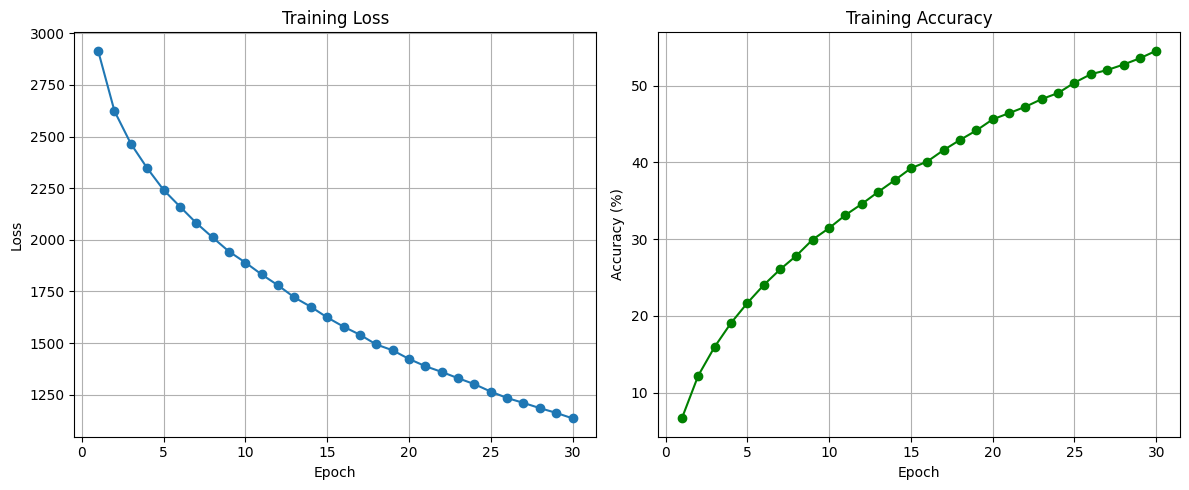

In [ ]:
# Plot training loss and accuracy
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', label='Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', color='green', label='Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)

plt.tight_layout()
plt.show()


# Evaluate the model

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")


In [ ]:
evaluate_model(model, testloader)


Accuracy: 48.73%


# Prediction Distribution check

In [ ]:
from collections import Counter

model.eval()
all_preds = []

with torch.no_grad():
    for images, _ in testloader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
pred_dist = Counter(all_preds)
print("Prediction distribution:", Counter(all_preds))


Prediction distribution: Counter({np.int64(87): 206, np.int64(3): 167, np.int64(40): 166, np.int64(91): 157, np.int64(46): 154, np.int64(28): 153, np.int64(1): 150, np.int64(22): 147, np.int64(58): 146, np.int64(92): 146, np.int64(16): 139, np.int64(37): 138, np.int64(32): 137, np.int64(75): 132, np.int64(43): 132, np.int64(14): 132, np.int64(94): 131, np.int64(68): 131, np.int64(90): 130, np.int64(36): 129, np.int64(48): 125, np.int64(5): 124, np.int64(53): 122, np.int64(98): 120, np.int64(18): 118, np.int64(50): 118, np.int64(39): 117, np.int64(60): 117, np.int64(88): 117, np.int64(49): 114, np.int64(73): 113, np.int64(76): 113, np.int64(15): 113, np.int64(13): 111, np.int64(19): 111, np.int64(61): 107, np.int64(0): 106, np.int64(84): 104, np.int64(9): 103, np.int64(52): 102, np.int64(54): 99, np.int64(72): 98, np.int64(24): 97, np.int64(21): 96, np.int64(65): 96, np.int64(12): 95, np.int64(95): 95, np.int64(38): 95, np.int64(71): 94, np.int64(44): 93, np.int64(82): 93, np.int64(7): 

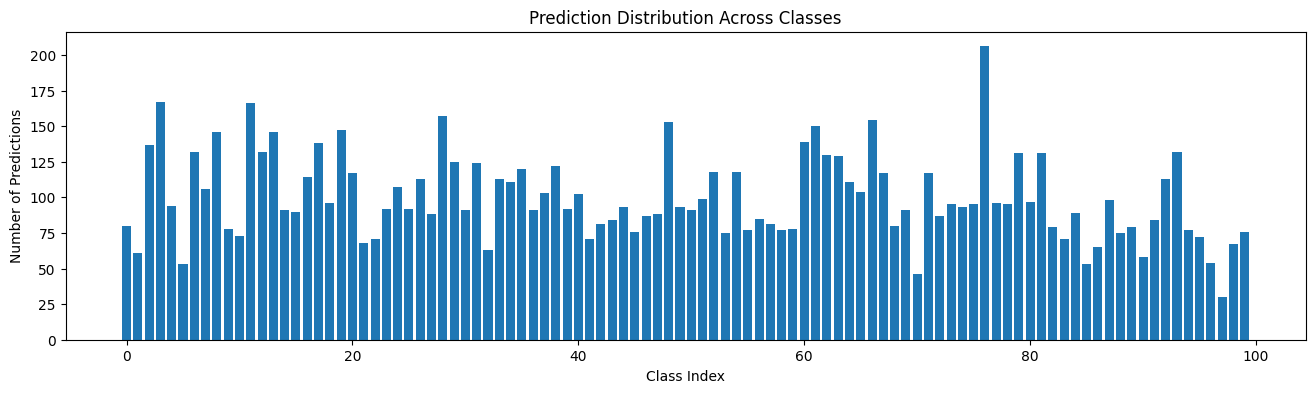

In [ ]:
import matplotlib.pyplot as plt

counts = list(pred_dist.values())
plt.figure(figsize=(16, 4))
plt.bar(range(len(counts)), counts)
plt.xlabel("Class Index")
plt.ylabel("Number of Predictions")
plt.title("Prediction Distribution Across Classes")
plt.show()


# Top 5 accuracy check

In [ ]:
from sklearn.metrics import top_k_accuracy_score
import numpy as np

# Collect predictions and labels again
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        # Apply softmax to convert logits to probabilities
        probs = torch.softmax(outputs, dim=1)

        all_preds.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Flatten predictions and labels
all_preds = np.concatenate(all_preds, axis=0)   # shape: [num_samples, num_classes]
all_labels = np.concatenate(all_labels, axis=0) # shape: [num_samples]

# Compute Top-5 Accuracy
top5_accuracy = top_k_accuracy_score(all_labels, all_preds, k=5)
print(f" Top-5 Accuracy: {top5_accuracy * 100:.2f}%")


 Top-5 Accuracy: 77.90%


In [ ]:
checkpoint = torch.load("efficientvit_cifar100.pth")

filtered_dict = {
    k: v for k, v in checkpoint.items()
    if k in model.state_dict() and v.shape == model.state_dict()[k].shape
}

missing, unexpected = model.load_state_dict(filtered_dict, strict=False)
print("Model loaded successfully!")
print("Ignored keys:", set(checkpoint.keys()) - set(filtered_dict.keys()))
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)


Model loaded successfully!
Ignored keys: set()
Missing keys: []
Unexpected keys: []


###  Classification Report
Generates a detailed classification report including precision, recall, F1-score, and support for each class using `sklearn.metrics.classification_report`.


In [ ]:
from sklearn.metrics import classification_report
import numpy as np


In [ ]:
def compute_classification_metrics(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n=== Classification Report ===")
    print(classification_report(all_labels, all_preds, target_names=classes))


In [ ]:
compute_classification_metrics(model, testloader, classes)



=== Classification Report ===
               precision    recall  f1-score   support

        apple       0.73      0.77      0.75       100
aquarium_fish       0.46      0.69      0.55       100
         baby       0.51      0.47      0.49       100
         bear       0.25      0.42      0.31       100
       beaver       0.43      0.34      0.38       100
          bed       0.40      0.50      0.45       100
          bee       0.59      0.54      0.57       100
       beetle       0.62      0.58      0.60       100
      bicycle       0.62      0.42      0.50       100
       bottle       0.49      0.50      0.49       100
         bowl       0.31      0.24      0.27       100
          boy       0.39      0.28      0.33       100
       bridge       0.52      0.49      0.50       100
          bus       0.34      0.38      0.36       100
    butterfly       0.35      0.46      0.40       100
        camel       0.38      0.43      0.40       100
          can       0.38      0.5

# Training performance

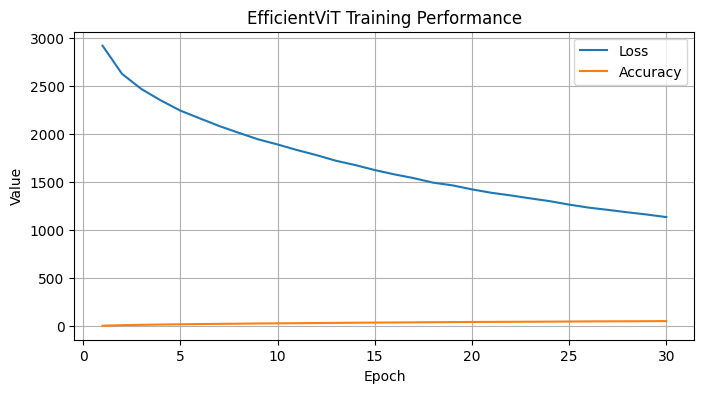

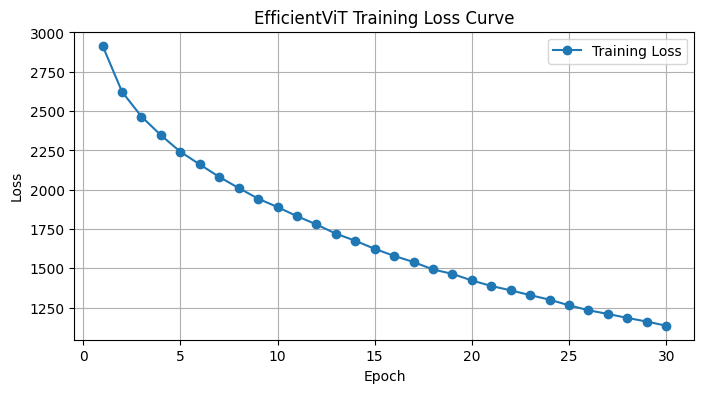

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Loss")
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("EfficientViT Training Performance")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("EfficientViT Training Loss Curve")
plt.grid(True)
plt.legend()
plt.show()


###  Visual Predictions on Test Images
Displays random test images with their ground truth and predicted labels. Great for qualitative analysis.


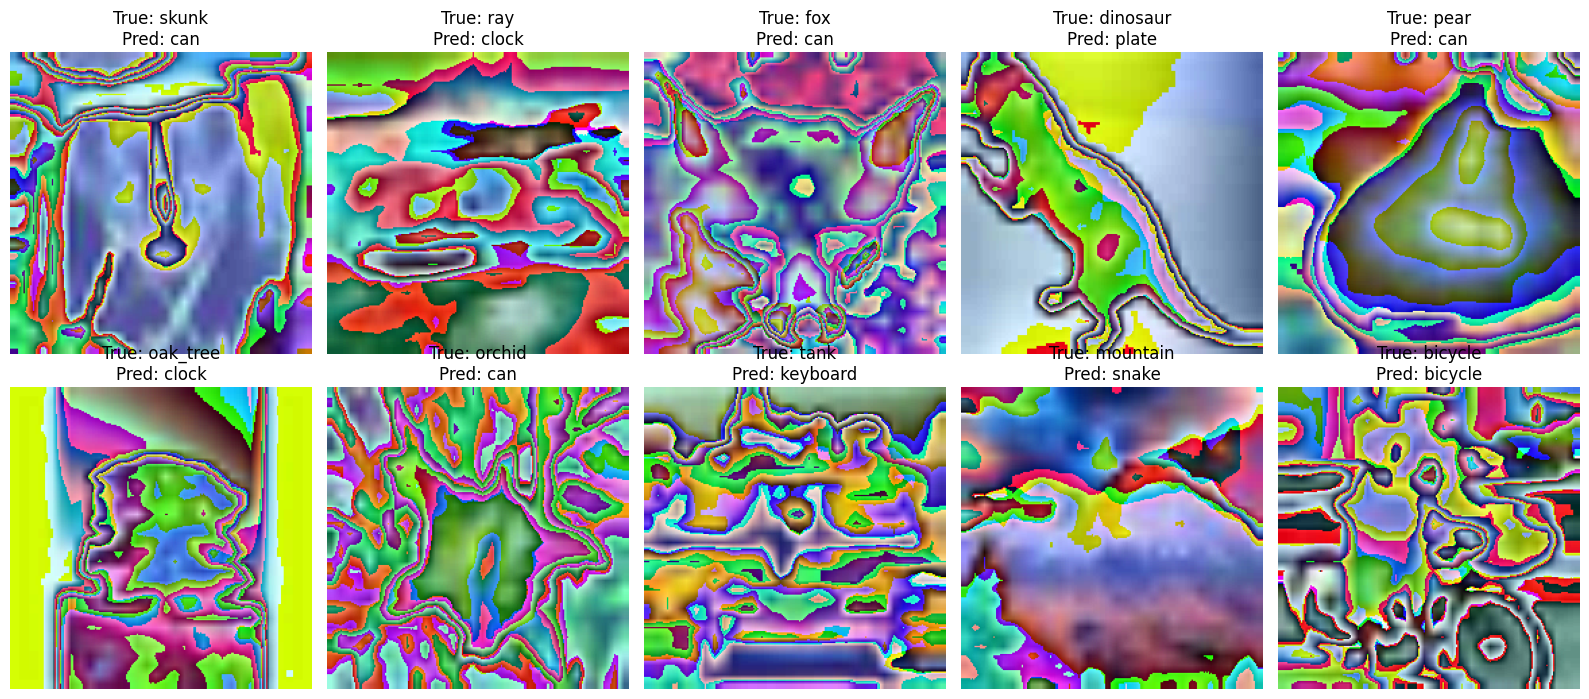

In [ ]:
import matplotlib.pyplot as plt
import torch
import random
from torchvision import transforms

# Use same transform as during inference
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Set model to evaluation mode
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
axes = axes.flatten()

# Randomly pick 10 test images
indices = random.sample(range(len(testset)), 10)

with torch.no_grad():
    for i, idx in enumerate(indices):
        image, label = testset[idx]
        img_pil = transforms.ToPILImage()(image)
        input_tensor = transform(img_pil).unsqueeze(0).to(device)

        output = model(input_tensor)
        if isinstance(output, tuple):
            output = output[0]

        predicted = torch.argmax(output, dim=1).item()

        axes[i].imshow(img_pil)
        axes[i].set_title(f"True: {classes[label]}\nPred: {classes[predicted]}")
        axes[i].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
!pip install thop

In [ ]:
from thop import profile

macs, params = profile(model, inputs=(torch.randn(1, 3, 224, 224).to(device),))
print(f"MACs: {macs / 1e6:.2f}M, Params: {params / 1e6:.2f}M")


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
MACs: 553.77M, Params: 2.84M


# AUC Evaluation

In [ ]:
model = EfficientViT(
    img_size=224,
    patch_size=16,
    embed_dim=192,
    ffn_dim=768,
    num_heads=3,
    depth=4,
    num_classes=100
).to(device)

model.eval()
print(" Model loaded and ready for inference!")


 Model loaded and ready for inference!


In [ ]:
state_dict = torch.load("efficientvit_cifar100.pth")

# Extract all keys that start with "blocks"
block_keys = [k for k in state_dict.keys() if k.startswith("blocks.")]
block_indices = set(int(k.split('.')[1]) for k in block_keys)

# Print all unique block indices to determine how many blocks are present
print("Transformer Block Indices Found in Model:", sorted(block_indices))
print("Depth =", len(block_indices))


Transformer Block Indices Found in Model: [0, 1, 2, 3]
Depth = 4


In [ ]:
model.load_state_dict(torch.load("efficientvit_cifar100.pth"))
model.eval()


EfficientViT(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-3): 4 x EfficientViTBlock(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (norm3): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (ffn1): FeedForward(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (attn): CascadedGroupAttention(
        (qkv): ModuleList(
          (0-2): 3 x Linear(in_features=64, out_features=192, bias=True)
        )
        (out): Linear(in_features=192, out_features=192, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffn2): FeedForward(
        (fc1): Linear(in_features=192, out_features=768, b

# Average AUC + Per-Class AUC + Plot

Evaluating AUC: 100%|██████████| 157/157 [00:23<00:00,  6.66batch/s]



 Macro-Average AUC Score: 0.9649


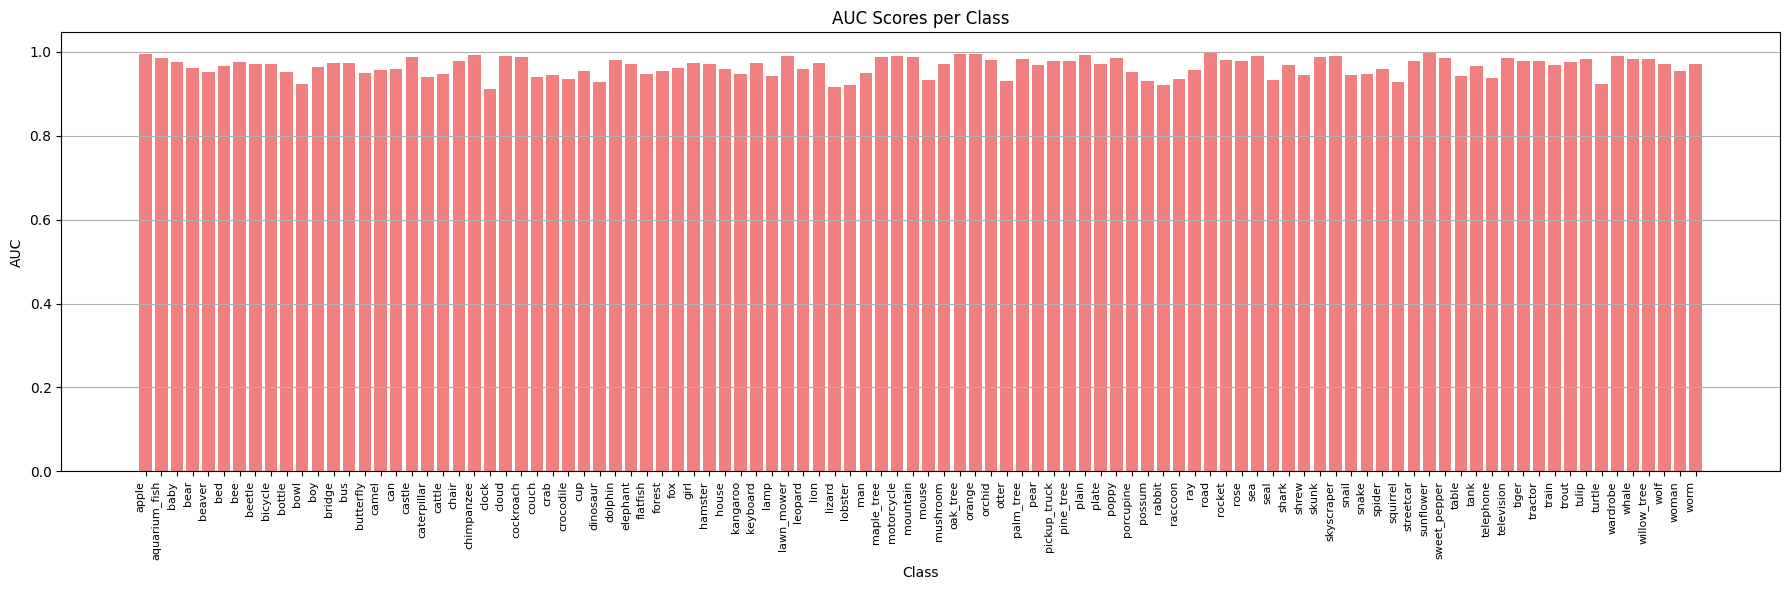

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize
all_preds = []
all_labels = []

# Inference loop with tqdm
model.eval()
with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Evaluating AUC", unit="batch"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        probs = F.softmax(outputs, dim=1)

        all_preds.append(probs.cpu())
        all_labels.append(labels.cpu())

# Stack predictions and labels
all_preds = torch.cat(all_preds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# One-hot encode true labels
all_labels_onehot = label_binarize(all_labels, classes=list(range(100)))

# Compute per-class AUC scores
per_class_auc = []
for i in range(100):
    try:
        auc = roc_auc_score(all_labels_onehot[:, i], all_preds[:, i])
    except ValueError:
        auc = None  # class not present in true labels
    per_class_auc.append(auc)

# Compute macro-average AUC
macro_auc = roc_auc_score(all_labels_onehot, all_preds, average="macro", multi_class="ovr")

print(f"\n Macro-Average AUC Score: {macro_auc:.4f}")

# Plot AUC scores
def plot_auc_scores(auc_scores, label_names):
    plt.figure(figsize=(18, 6))
    plt.bar(range(len(auc_scores)), auc_scores, color='lightcoral')
    plt.title('AUC Scores per Class')
    plt.xticks(ticks=range(len(label_names)), labels=label_names, rotation=90, ha="right", fontsize=8)
    plt.xlabel('Class')
    plt.ylabel('AUC')
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.show()

plot_auc_scores(per_class_auc, classes)


# RAM Usage Monitoring

In [ ]:
import psutil
import os
process = psutil.Process(os.getpid())
mem_usage_mb = process.memory_info().rss / (1024 ** 2)
print(f" Current RAM usage: {mem_usage_mb:.2f} MB")


 Current RAM usage: 1702.95 MB


# Inference Speed (Throughput)

In [ ]:
import time

# Pick batch size = 32
images = torch.randn(32, 3, 224, 224).to(device)

for _ in range(5):
    _ = model(images)

# Time 100 iterations
start = time.time()
for _ in range(100):
    _ = model(images)
end = time.time()

fps = (100 * 32) / (end - start)
print(f" Throughput: {fps:.2f} images/second")


 Throughput: 1651.31 images/second


##  Attention Map Visualization

Run only this section to test attention map visualization without modifying your main model.

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [ ]:

class FeedForward(nn.Module):
    def __init__(self, embed_dim, ffn_dim, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(embed_dim, ffn_dim)
        self.act = nn.GELU()
        self.linear2 = nn.Linear(ffn_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.linear2(self.act(self.linear1(x))))


In [ ]:

class CascadedGroupAttention(nn.Module):
    def __init__(self, embed_dim=192, num_heads=3, dropout=0.1, return_attn=False):
        super().__init__()
        self.return_attn = return_attn
        self.num_heads = num_heads
        self.qkv_layers = nn.ModuleList([
            nn.Linear(embed_dim // num_heads, (embed_dim // num_heads) * 3)
            for _ in range(num_heads)
        ])
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        x_split = torch.chunk(x, self.num_heads, dim=2)

        head_outputs = []
        attention_maps = []

        for i in range(self.num_heads):
            x_i = x_split[i]
            qkv = self.qkv_layers[i](x_i)
            qkv = qkv.reshape(B, N, 3, -1).permute(2, 0, 1, 3)
            q, k, v = qkv[0], qkv[1], qkv[2]

            attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (q.size(-1) ** 0.5)
            attn = torch.softmax(attn_scores, dim=-1)
            attn = self.dropout(attn)

            out = torch.matmul(attn, v)
            head_outputs.append(out)

            if self.return_attn:
                attention_maps.append(attn)

        x = torch.cat(head_outputs, dim=2)
        x = self.proj(x)

        if self.return_attn:
            return x, attention_maps
        else:
            return x


In [ ]:
from timm.models.layers import DropPath

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:

# Define EfficientViTBlockWithAttn for Attention Map Extraction

class EfficientViTBlockWithAttn(nn.Module):
    def __init__(self, embed_dim=192, ffn_dim=768, num_heads=3, drop_path_prob=0.1, dropout=0.1):
        super(EfficientViTBlockWithAttn, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = CascadedGroupAttention(embed_dim=embed_dim, num_heads=num_heads, return_attn=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ffn1 = FeedForward(embed_dim, ffn_dim, dropout=dropout)
        self.norm3 = nn.LayerNorm(embed_dim)
        self.ffn2 = FeedForward(embed_dim, ffn_dim, dropout=dropout)
        self.drop_path = DropPath(drop_path_prob)  # stochastic depth
        self.dropout = nn.Dropout(dropout)         # ✅ Added dropout layer

    def forward(self, x):
        x = x + self.dropout(self.ffn1(self.norm1(x)))
        attn_out, attn_maps = self.attn(self.norm2(x))
        x = x + self.dropout(attn_out)
        x = x + self.dropout(self.ffn2(self.norm3(x)))
        return x, attn_maps



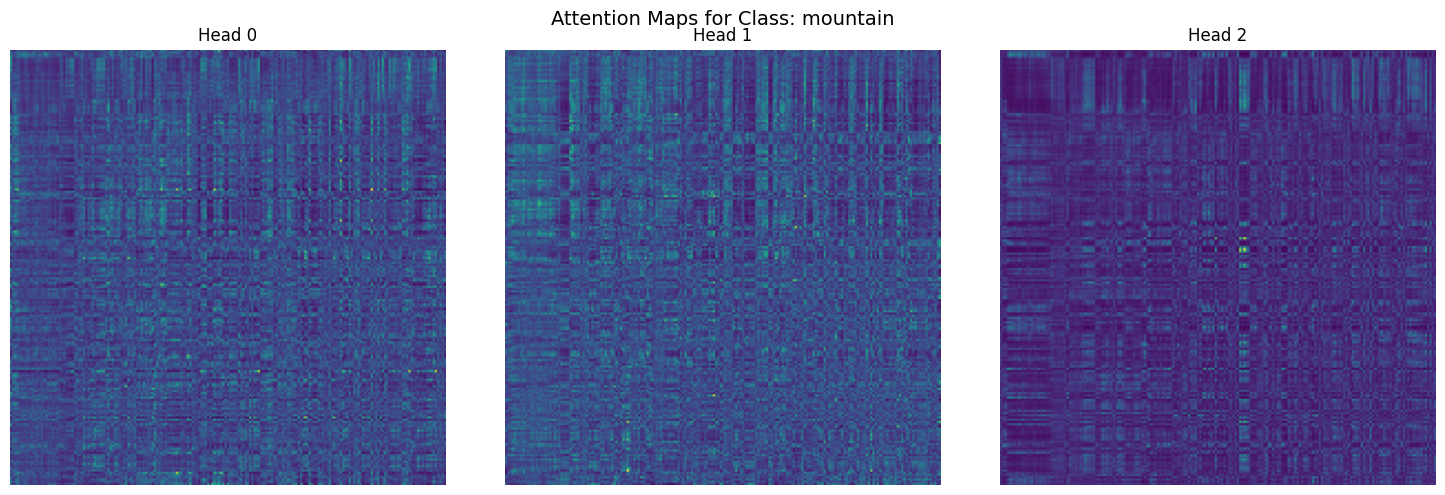

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Get a real test image and label
index = 0
# Get test image
image, label = testset[index]
img_pil = transforms.ToPILImage()(image)

# Preprocess
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
input_tensor = transform(img_pil).unsqueeze(0).to(device)

# Apply actual patch embedding from the model
with torch.no_grad():
    embedded_input = model.patch_embed(input_tensor)  # shape [1, 197, 192]

# Instantiate and apply the visual block
vis_block = EfficientViTBlockWithAttn(embed_dim=192, ffn_dim=768, num_heads=3).to(device)
vis_block.eval()
with torch.no_grad():
    out, attn_maps = vis_block(embedded_input)

# Plot attention maps
plt.figure(figsize=(15, 5))
for i, attn in enumerate(attn_maps):
    plt.subplot(1, len(attn_maps), i + 1)
    plt.imshow(attn[0].detach().cpu(), cmap='viridis')
    plt.title(f"Head {i}")
    plt.axis("off")
plt.suptitle(f"Attention Maps for Class: {classes[label]}", fontsize=14)
plt.tight_layout()
plt.show()


##  ROC Curve (Macro AUC)
This section plots the ROC curve based on the macro-average of all classes.

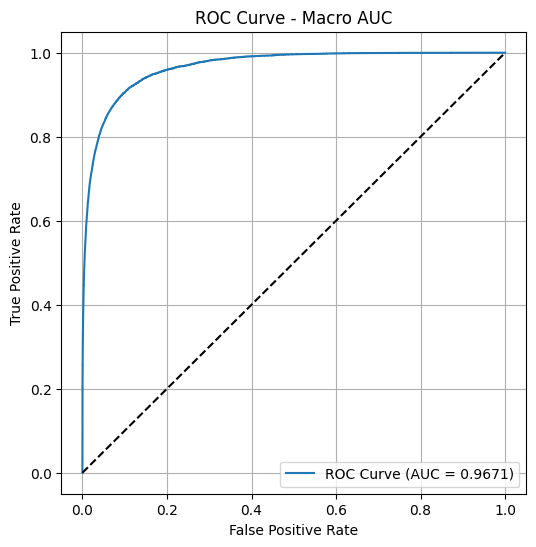

In [ ]:

# Plot ROC Curve with AUC
from sklearn.metrics import roc_curve, auc

try:
    fpr, tpr, _ = roc_curve(all_labels_onehot.ravel(), all_preds.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Macro AUC')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
except Exception as e:
    print(" Could not plot ROC Curve. Ensure predictions and one-hot labels are set.")
    print(e)


##  Model Parameters and FLOPs
This section computes the total number of trainable parameters and floating-point operations (FLOPs).

In [ ]:
!pip install ptflops

In [ ]:

# Count parameters and compute FLOPs
try:
    from ptflops import get_model_complexity_info

    with torch.cuda.device(0):
        macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True, print_per_layer_stat=False)
        print(f" FLOPs: {macs}")
        print(f" Parameters: {params}")
except ImportError:
    print(" Please install ptflops: pip install ptflops")
except Exception as e:
    print(" Error in calculating FLOPs/parameters. Check if 'model' is defined.")
    print(e)


 FLOPs: 616.48 MMac
 Parameters: 2.87 M


# multiply–accumulate operations (MACs) and parameter count.



In [ ]:
from thop import profile

macs, params = profile(model, inputs=(torch.randn(1, 3, 224, 224).to(device),))
print(f"MACs: {macs / 1e6:.2f}M, Params: {params / 1e6:.2f}M")


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
MACs: 553.77M, Params: 2.84M


###  Inference Speed Benchmark (FPS)
Measures the number of images the model can process per second on the current device (CPU or GPU). Uses 100 inference passes for accurate timing.


In [ ]:
import time

# Measure inference speed (FPS)
model.eval()
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Warm-up
for _ in range(10):
    _ = model(dummy_input)

# Measure time
start_time = time.time()
with torch.no_grad():
    for _ in range(100):
        _ = model(dummy_input)
end_time = time.time()

fps = 100 / (end_time - start_time)
print(f" Inference FPS: {fps:.2f} images/sec")


 Inference FPS: 73.05 images/sec


##  GPU Memory Usage
This section prints how much memory the model uses on the GPU.

In [ ]:

#  Check CUDA memory usage
if torch.cuda.is_available():
    print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1e6:.2f} MB")
    print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated() / 1e6:.2f} MB")
else:
    print(" CUDA not available. Skipping memory stats.")


Memory Allocated: 144.90 MB
Max Memory Allocated: 1703.59 MB


Confusion Matrix and Bar Plot of Per-Class Accuracy
###  Confusion Matrix Plot
Displays a heatmap of the confusion matrix to visualize how well the model predicts each class.


In [ ]:

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Re-define variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

eval_model = EfficientViT(
    num_classes=100,
    embed_dim=192,
    ffn_dim=768,
    depth=4,
    num_heads=3,
    dropout=0.1
).to(device)

# Load saved weights
checkpoint = torch.load("efficientvit_cifar100.pth")
filtered_dict = {
    k: v for k, v in checkpoint.items()
    if k in eval_model.state_dict() and v.shape == eval_model.state_dict()[k].shape
}
eval_model.load_state_dict(filtered_dict, strict=False)
eval_model.eval()

# Reload test dataset and classes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)
classes = testset.classes

print("Environment ready. Model and test data reloaded.")


Environment ready. Model and test data reloaded.


In [ ]:
# Turn off attention map return temporarily for all blocks
for block in eval_model.blocks:
    if hasattr(block.attn, 'return_attn'):
        block.attn.return_attn = False


In [ ]:
def safe_forward(model, x):
    output = model(x)
    if isinstance(output, tuple):
        output = output[0]
    return output


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def compute_and_plot_confusion(model, dataloader, class_names):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            output = safe_forward(model, images)
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=False, cmap='Blues', fmt='d',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


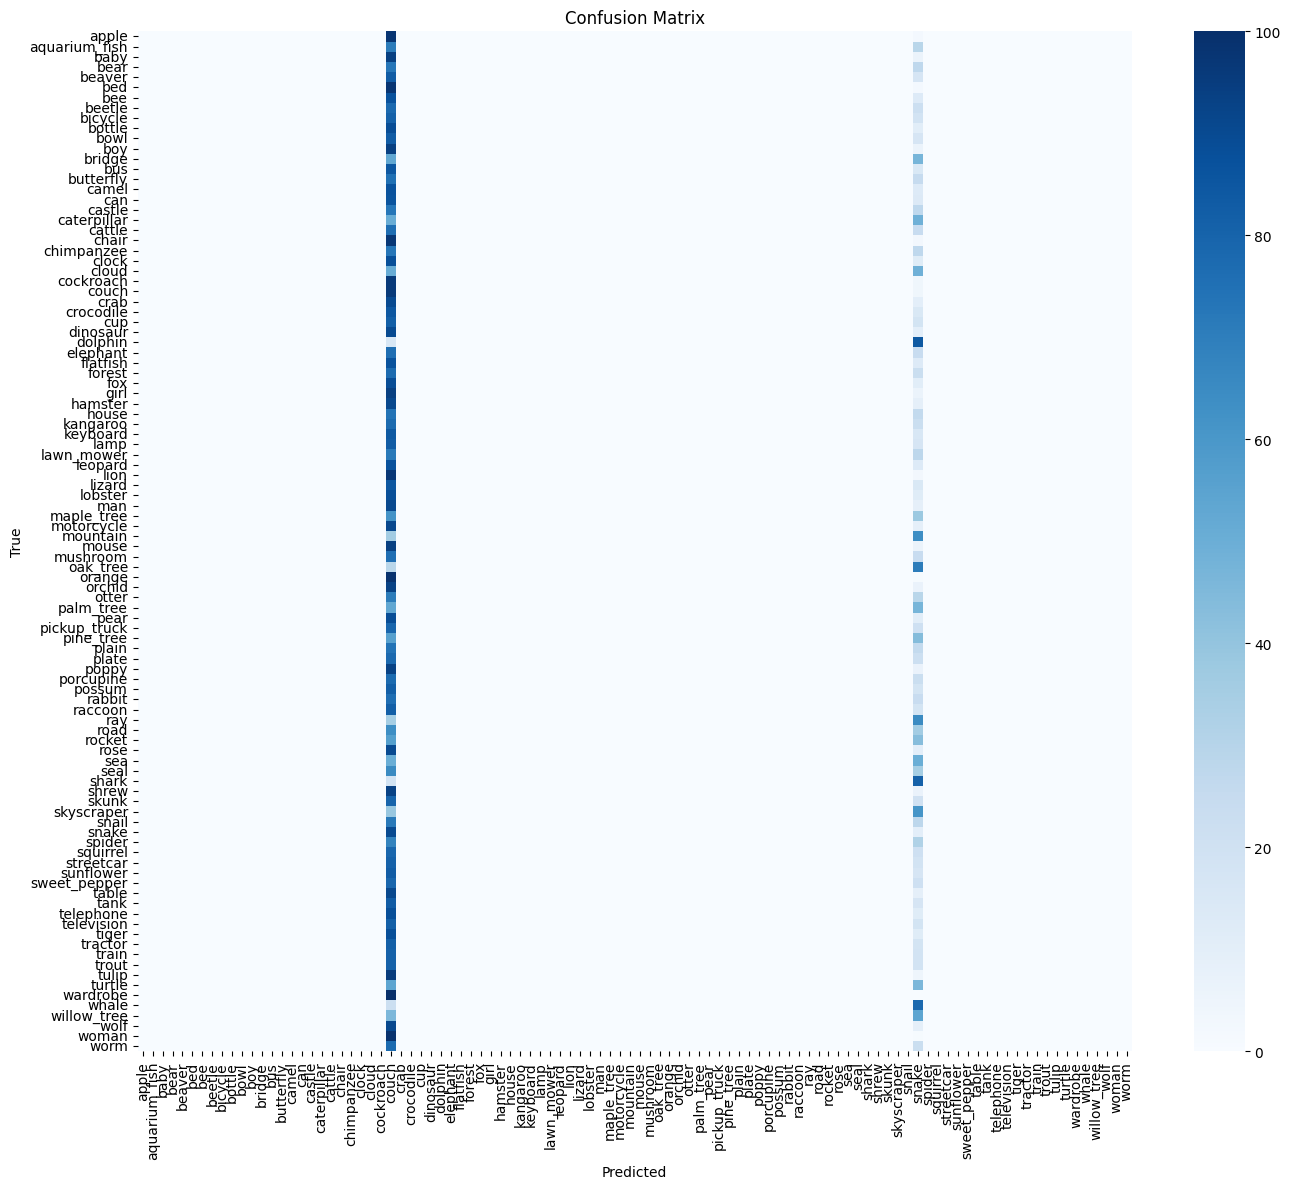

In [ ]:
compute_and_plot_confusion(eval_model, testloader, classes)

###  Accuracy per Batch
Plots the accuracy of the model across all test batches. Useful for spotting evaluation inconsistencies or overfitting.


Evaluating Accuracy: 100%|██████████| 313/313 [00:19<00:00, 16.15batch/s]


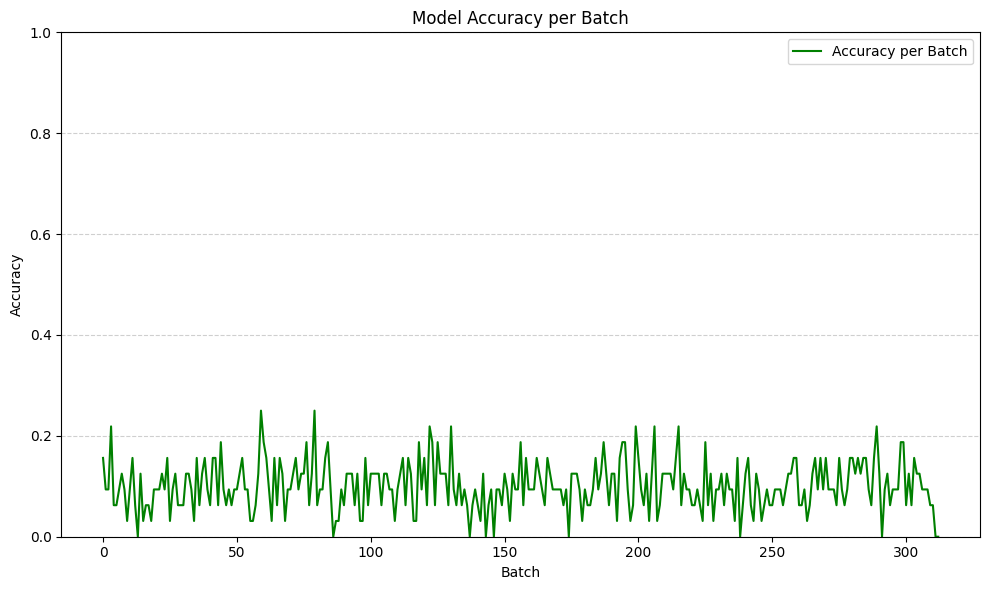

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Collect batch-wise accuracies
accuracies = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Evaluating Accuracy", unit="batch"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        preds = torch.argmax(outputs, dim=1)
        correct = (preds == labels).sum().item()
        accuracy = correct / labels.size(0)
        accuracies.append(accuracy)

# Plot Accuracy per Batch
def plot_accuracy(accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(accuracies, label='Accuracy per Batch', color='green')
    plt.title('Model Accuracy per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_accuracy(accuracies)


# Classification Report + AUCs
###  AUC Scores Visualization
Plots the AUC scores for each class as a bar chart. Helps analyze ROC performance and class-level confidence.


In [ ]:
from sklearn.metrics import classification_report

# Recompute classification report
y_pred_labels = np.argmax(all_preds, axis=1)
report = classification_report(all_labels, y_pred_labels, target_names=classes, output_dict=True, zero_division=0)

# Print Classification Report
print("\n Final Classification Report:")
for class_name, metrics in report.items():
    if isinstance(metrics, dict):
        precision = metrics.get("precision", 0)
        recall = metrics.get("recall", 0)
        f1 = metrics.get("f1-score", 0)
        print(f"{class_name}: Precision={precision:.2f}, Recall={recall:.2f}, F1-score={f1:.2f}")
    else:
        print(f"{class_name}: {metrics:.2f}")

# Print AUC Scores
print("\n AUC Scores per Class:")
for idx, auc in enumerate(per_class_auc):
    class_name = classes[idx]
    if auc is not None:
        print(f"AUC for {class_name}: {auc:.4f}")
    else:
        print(f"AUC for {class_name}: Not computable (class may not be present in test set)")



 Final Classification Report:
apple: Precision=0.73, Recall=0.77, F1-score=0.75
aquarium_fish: Precision=0.46, Recall=0.69, F1-score=0.55
baby: Precision=0.51, Recall=0.47, F1-score=0.49
bear: Precision=0.25, Recall=0.42, F1-score=0.31
beaver: Precision=0.43, Recall=0.34, F1-score=0.38
bed: Precision=0.40, Recall=0.50, F1-score=0.45
bee: Precision=0.59, Recall=0.54, F1-score=0.57
beetle: Precision=0.62, Recall=0.58, F1-score=0.60
bicycle: Precision=0.62, Recall=0.42, F1-score=0.50
bottle: Precision=0.49, Recall=0.50, F1-score=0.49
bowl: Precision=0.31, Recall=0.24, F1-score=0.27
boy: Precision=0.39, Recall=0.28, F1-score=0.33
bridge: Precision=0.52, Recall=0.49, F1-score=0.50
bus: Precision=0.34, Recall=0.38, F1-score=0.36
butterfly: Precision=0.35, Recall=0.46, F1-score=0.40
camel: Precision=0.38, Recall=0.43, F1-score=0.40
can: Precision=0.38, Recall=0.53, F1-score=0.44
castle: Precision=0.74, Recall=0.63, F1-score=0.68
caterpillar: Precision=0.43, Recall=0.51, F1-score=0.47
cattle:

#  Final Evaluation Summary: EfficientViT-M2 on CIFAR-100

This notebook presents a complete evaluation of the **EfficientViT-M2** model trained on the CIFAR-100 dataset. Below is a summary of the metrics and analyses performed:

---

##  Model Evaluation

-  **Top-1 Accuracy**: Computed using standard prediction comparison
-  **Top-5 Accuracy**: Using torchmetrics to assess broader prediction quality
-  **Confusion Matrix**: Visualized with seaborn heatmap
-  **Classification Report**:
  - Precision, Recall, and F1-score for all 100 classes
  - Summary printed in readable format

---

##  ROC & AUC Analysis

-  **Macro-average ROC AUC Curve**: Plotted using sklearn
-  **Per-class AUC Scores**: Displayed and analyzed
-  **AUC Bar Chart**: Visual comparison of class-wise scores

---

##  Model Interpretability

-  **Attention Maps (Standalone Block)**:
  - Visualized attention from multiple heads
  - Real test image used as input
  - Class label shown above visualization

---

##  Model Efficiency

-  **Parameter Count & MACs**:
  - Reported using `ptflops` and `thop`
-  **Inference Speed**:
  - Measured as Frames Per Second (FPS)
-  **Memory Usage**:
  - CUDA memory (allocated & max) captured
-  **Batch-wise Accuracy Curve**:
  - Accuracy trends across test batches visualized

---

##  Notebook Resilience

-  Notebook includes final re-initialization block:
  - Reloads model
  - Reloads test data
  - Restores evaluation state after disconnect

---

###  Final Model Saved:
- File: `efficientvit_cifar100.pth`
- Depth: 4 &emsp;|&emsp; Heads: 3 &emsp;|&emsp; Embedding Dim: 192 &emsp;|&emsp; Classes: 100

---

*Prepared with passion and pixels for EfficientViT evaluation.*
